In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, robust_smooth, tangential_velocity, fit_psi_params, psi_params


### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_1D.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = np.squeeze(ssh_dataset['uo'][:].data), np.squeeze(ssh_dataset['vo'][:].data) 
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


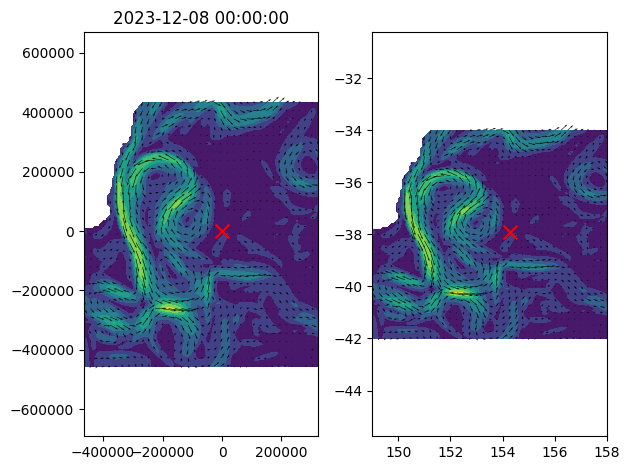

In [3]:
t_idx = 50
time = list(dic_ssh_data.keys())[t_idx]
dic = dic_ssh_data[time]
ut, vt = dic['u'], dic['v']

fig, axs = plt.subplots(1, 2)

axs[0].contourf(x_ssh, y_ssh, np.hypot(ut, vt))
spac = 3
axs[0].quiver(x_ssh[::spac, ::spac], y_ssh[::spac, ::spac],
           ut[::spac, ::spac], vt[::spac, ::spac])
axs[0].scatter(0,0, marker='x', color='r', s=100)
axs[0].axis('equal'); axs[0].set_title(time)

axs[1].contourf(lon_ssh, lat_ssh, np.hypot(ut, vt))
spac = 3
axs[1].quiver(lon_ssh[::spac, ::spac], lat_ssh[::spac, ::spac],
           ut[::spac, ::spac], vt[::spac, ::spac])
axs[1].scatter(theta_mean, phi_mean, marker='x', color='r', s=100)
axs[1].axis('equal'); axs[0].set_title(time)
# axs[1].set_xlim(152, 156); axs[1].set_ylim(-39, -36);

plt.tight_layout()



,xc,yc,w,Q,Rc,psi0,A,r2_1,Time
0,-5802.908374,-1563.771988,-0.000037,"[[1.0301643105849614, -0.08332720822216222], [...",86754.804799,65105.330085,-0.000009,0.992436,2023-10-19 00:00:00
1,-4981.140748,-26.429374,-0.000036,"[[0.9631693575540718, -0.10730452108581083], [...",82205.548129,61630.950345,-0.000009,0.989580,2023-10-19 23:56:15
2,-8885.799690,-4721.730306,-0.000037,"[[0.9255072352056705, -0.1185051228863016], [-...",88187.416957,66000.999166,-0.000008,0.990015,2023-10-21 00:00:00
3,-4142.215128,-4567.341615,-0.000038,"[[0.870303241417468, -0.12170574479314025], [-...",83651.074577,63270.612324,-0.000009,0.993006,2023-10-22 00:00:00
4,-1078.521019,-4746.479963,-0.000038,"[[0.8168376219820783, -0.06486040912522494], [...",82340.649335,62005.887579,-0.000009,0.992719,2023-10-22 23:56:15
...,...,...,...,...,...,...,...,...,...
104,-297737.567092,156754.359903,-0.000020,"[[0.8470330042814647, 0.00846037253683076], [0...",66220.813174,23846.353941,-0.000005,0.933604,2024-01-31 00:00:00
105,-298005.530824,156269.898688,-0.000021,"[[0.8973369092907337, 0.2778837355453176], [0....",62172.960041,22114.972084,-0.000006,0.913641,2024-02-01 00:00:00
106,-300565.349212,165500.883450,-0.000022,"[[1.3276634948890262, 0.4330534110361884], [0....",67153.854306,25429.803854,-0.000006,0.947802,2024-02-02 00:00:00
107,-308726.488912,154030.512188,-0.000024,"[[2.4882099130928554, 0.389587848686837], [0.3...",106418.988841,30799.876268,-0.000003,0.941040,2024-02-02 23:56:15


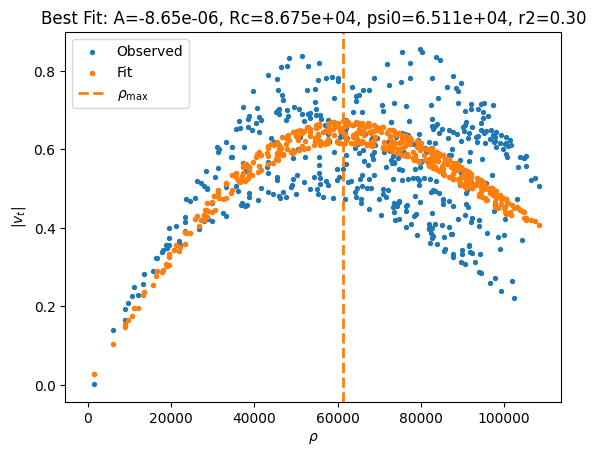

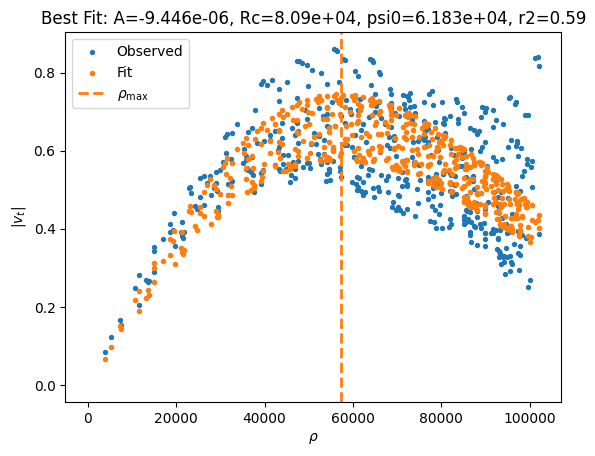

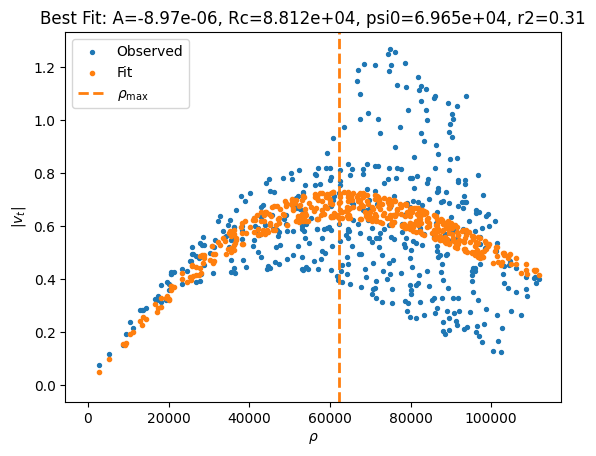

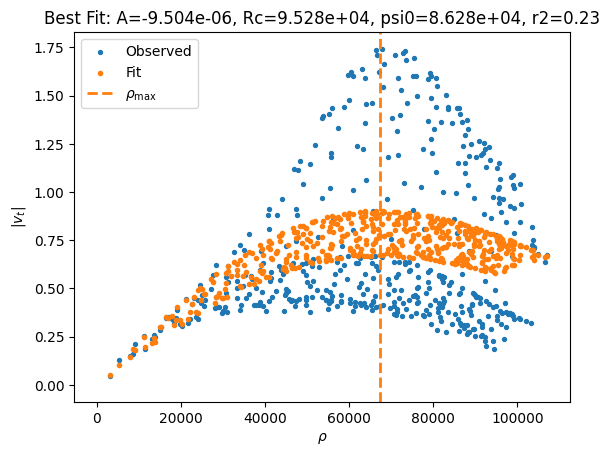

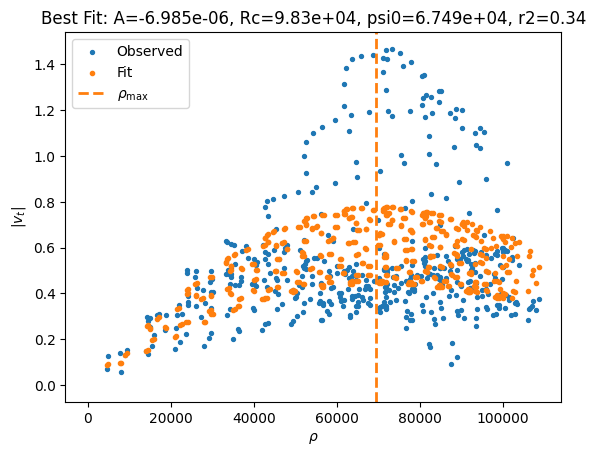

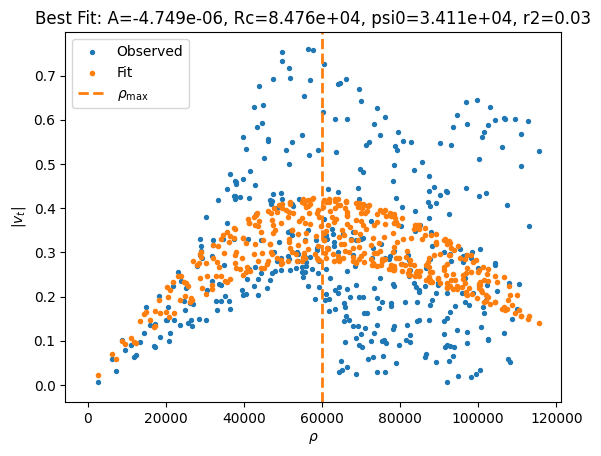

In [4]:
xc_pre, yc_pre = 0, 0
q11_pre, q12_pre, q22_pre = 1, 0, 1
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'r2_1', 'Time'])
rho_core_thresh = 30000
rho_outer_core_thresh = 100000
dic_params = {}
for k, t_idx in enumerate(range(len(dic_ssh_data))):
    time = list(dic_ssh_data.keys())[t_idx]
    dic = dic_ssh_data[time]
    ut, vt = dic['u'], dic['v']

    dx, dy = x_ssh - xc_pre, y_ssh - yc_pre
    rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
    mask_core = rho_search < rho_core_thresh
    xi, yi, ui, vi = x_ssh[mask_core], y_ssh[mask_core], ut[mask_core], vt[mask_core]
    xc, yc, w, Q, _, _, A0, r2_1, _ = espra(xi, yi, ui, vi, Rc_max=150000, r2_flag=True)
    # All
    mask_outer = rho_search < rho_outer_core_thresh
    axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], ut[mask_outer], vt[mask_outer]

    if (np.hypot(xc-xc_pre, yc-yc_pre)<100000) & (np.sign(w)<0):

        df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
        df = df[df.vt < 0]
        Rc, psi0, A = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0, Rc_max=150000, plot=True if k%20==0 else False)
        
        if A >= 0:
            Rc, psi0, A = np.nan, np.nan, np.nan
        # else:
            # rho_core_thresh = Rc/2
            # rho_outer_core_thresh = Rc*1.5
        df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                                   'Rc': Rc, 'psi0': psi0, 'A': A, 'r2_1': r2_1, 'Time': time}
        xc_pre, yc_pre = xc, yc
        q11_pre, q12_pre, q22_pre = Q[0,0], Q[1,0], Q[1,1]
        # Gather data for better psi param fit
        dic_params[time] = psi_params(xc, yc, Q, axi, ayi, aui, avi)
    else:
        break
df_res


In [5]:
def combine_with_adjacent(dfs: dict, order=None, k=1, how='outer', include_self=True, ignore_index=True, dedup=False):
    """
    Build a new dict with the same keys where each value is the concat of its
    own DataFrame and its k adjacent neighbours in `order`.

    Parameters
    ----------
    dfs : dict[key -> pd.DataFrame]
        Original mapping.
    order : list | None
        Sequence defining adjacency. If None, uses dict insertion order.
        If None and keys are sortable, falls back to sorted(dfs).
    k : int
        Number of neighbours on each side to include (window radius).
    how : {'outer','inner'}
        Join type used by pd.concat to align columns.
    include_self : bool
        If False, excludes the key’s own DataFrame (rare, but supported).
    ignore_index : bool
        Passed to pd.concat.
    dedup : bool
        If True, drop duplicate rows after concat.

    Returns
    -------
    dict[key -> pd.DataFrame]
    """
    if order is None:
        # Try insertion order; if keys not ordered, fall back to sorted if possible
        try:
            order = list(dfs.keys())
        except Exception:
            order = None
    if order is None:
        try:
            order = sorted(dfs.keys())
        except Exception:
            raise ValueError("Provide `order` to define adjacency.")

    idx_map = {k_: i for i, k_ in enumerate(order)}
    out = {}

    for key in order:
        i = idx_map[key]
        left = max(0, i - k)
        right = min(len(order), i + k + 1)
        window_keys = order[left:right]
        if not include_self:
            window_keys = [wk for wk in window_keys if wk != key]

        frames = [dfs[wk] for wk in window_keys]
        combined = pd.concat(frames, axis=0, join=how, ignore_index=ignore_index, sort=False)
        if dedup:
            combined = combined.drop_duplicates()
        out[key] = combined

    return out

new_dfs = combine_with_adjacent(dic_params, k=3)


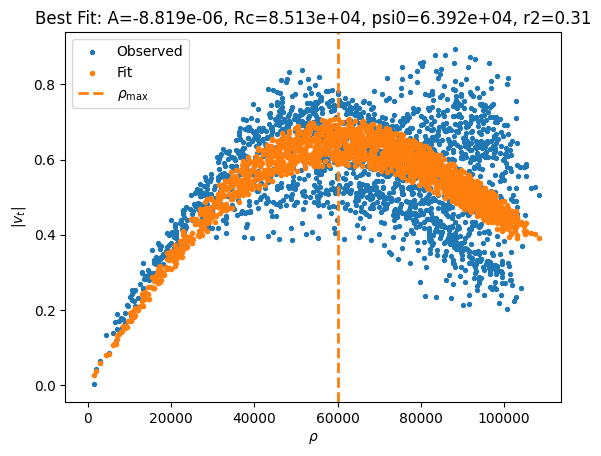

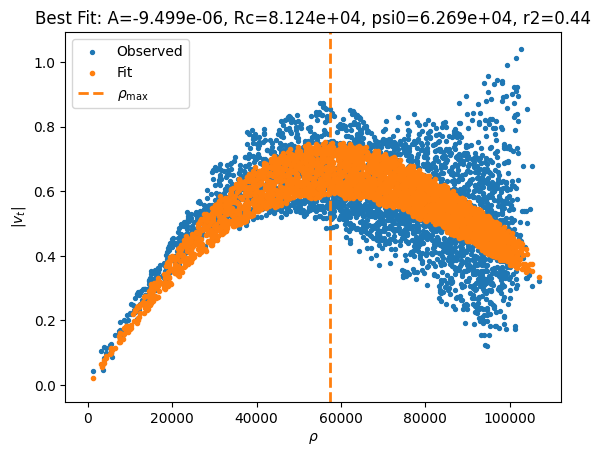

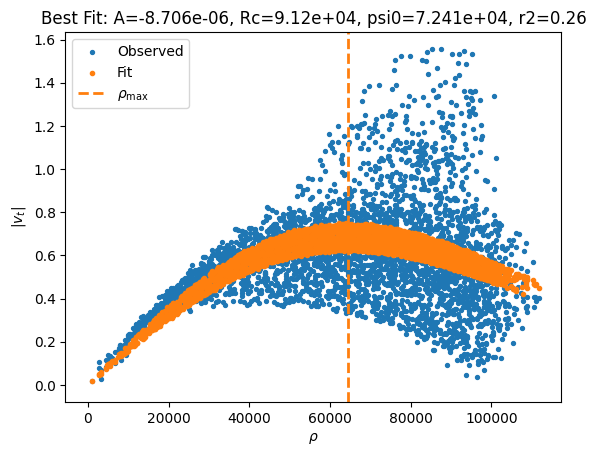

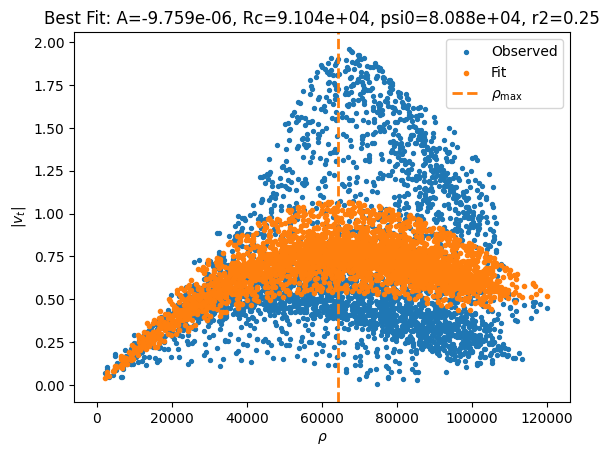

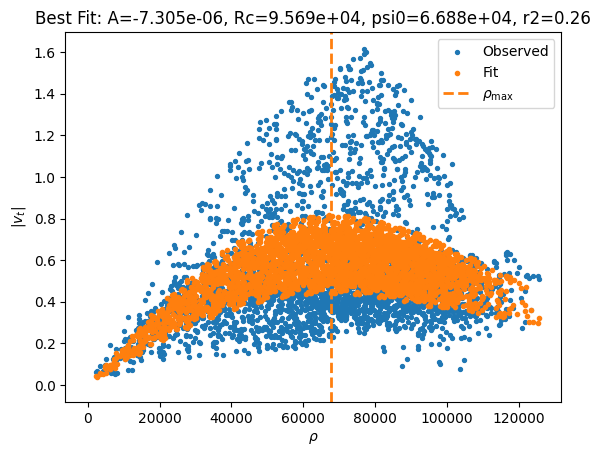

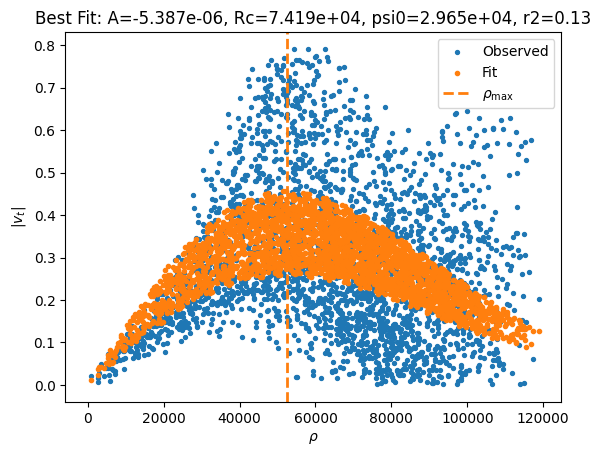

In [6]:
Rcs, psi0s, As = [], [], []
r2_2s = []
for k, time in enumerate(new_dfs.keys()):
    df = new_dfs[time].copy()
    df = df[df.vt <= 0]
    Rc_opt, psi0_opt, A_opt, r2_2 = fit_psi_params(df.rho2, df.Qr, df.vt, r2_flag=True, 
                                             plot=True if k%20==0 else False, Rc_max=1e6) 
    Rcs.append(Rc_opt); psi0s.append(psi0_opt); As.append(A_opt)
    r2_2s.append(r2_2)
df_res['Rc_opt'] = Rcs; df_res['psi0_opt'] = psi0s; df_res['A_opt'] = As
df_res['r2_2'] = r2_2s


(np.float64(-326563.34498084366),
 np.float64(14881.438018587623),
 np.float64(-17075.144035599256),
 np.float64(192140.69035727007))

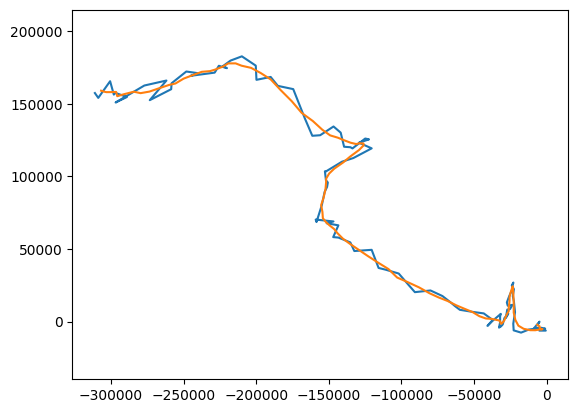

In [7]:
wdw = 5
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)

plt.axis('equal')


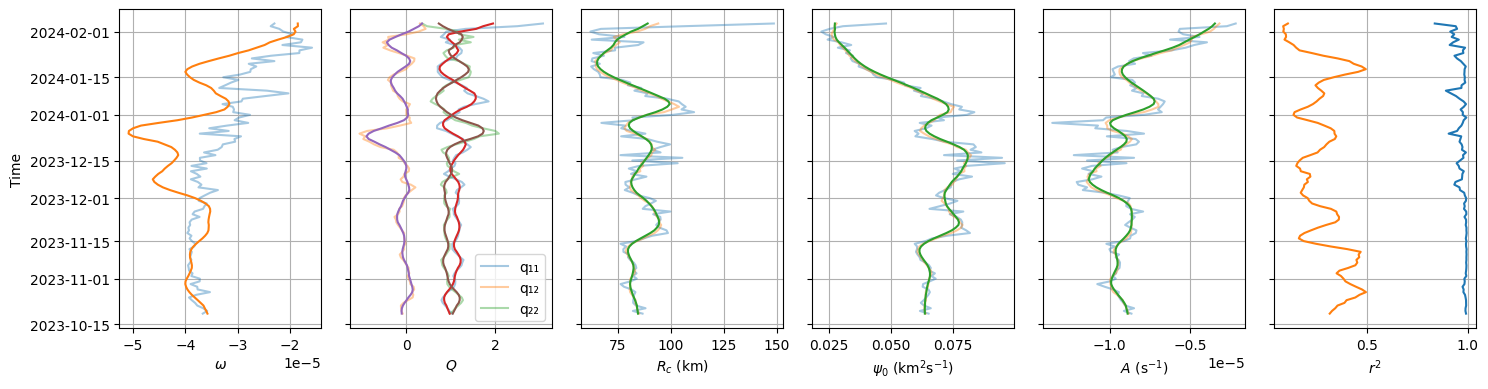

In [8]:
wdw = 6
# df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc_opt, df_res.Time, window=wdw, num=len(df_res)) 
# df_res['spsi0'] = smooth(df_res.psi0_opt, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A_opt, df_res.Time, window=wdw, num=len(df_res)) 

# Optimal 
df_res['sw'] = 2*df_res.sA*(df_res.sq11 + df_res.sq22)
df_res['spsi0'] = -df_res.sA*df_res.sRc**2

fig, axs = plt.subplots(1, 6, figsize=(15,4), sharey=True)
alpha = .4

axs[0].plot(df_res.w, df_res.Time, alpha=alpha)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel(r'$\omega$')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂', alpha=alpha)
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel(r'$Q$')
axs[1].legend()

axs[2].plot(df_res.Rc/1e3, df_res.Time, alpha=alpha)
axs[2].plot(df_res.Rc_opt/1e3, df_res.Time, alpha=alpha)
axs[2].plot(df_res.sRc/1e3, df_res.Time)
axs[2].set_xlabel(r'$R_c$ (km)')

axs[3].plot(df_res.psi0/1e6, df_res.Time, alpha=alpha)
axs[3].plot(df_res.psi0_opt/1e6, df_res.Time, alpha=alpha)
axs[3].plot(df_res.spsi0/1e6, df_res.Time)
axs[3].set_xlabel(r'$\psi_0$ (km$^2$s$^{-1}$)')

axs[4].plot(df_res.A, df_res.Time, alpha=alpha)
axs[4].plot(df_res.A_opt, df_res.Time, alpha=alpha)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel(r'$A$ (s$^{-1}$)')

axs[5].plot(df_res.r2_1, df_res.Time)
axs[5].plot(df_res.r2_2, df_res.Time)
axs[5].set_xlabel(r'$r^2$')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


In [9]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 


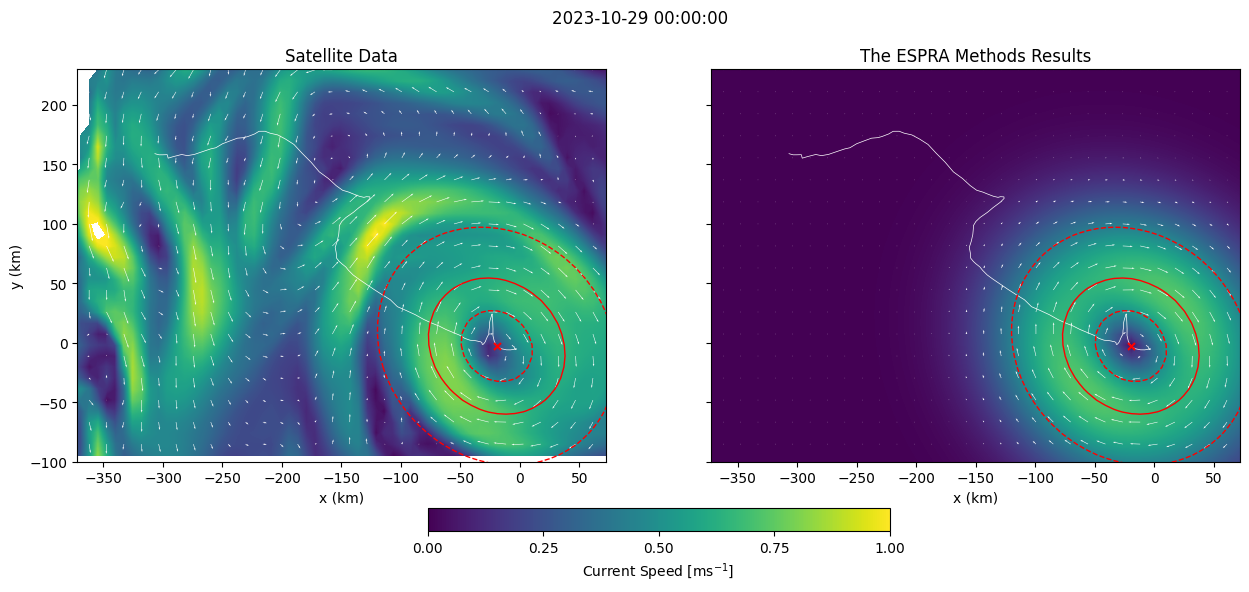

In [15]:
t_idx = 10
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

data = df_res.iloc[t_idx]

# data & masks
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

u, v = U[:,:,t_idx], V[:,:,t_idx]
spd2 = np.hypot(u, v)

# shared colour scale: force 0 baseline, use combined max, and FIX levels
vmin = 0.0
# vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
vmax = 1
cmap = 'viridis'
levels = np.linspace(vmin, vmax, 256)  # identical bins for both
norm = plt.Normalize(vmin, vmax)

# --- plot 1 ---
cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 2
axs[0].quiver(x_ssh[::spac, ::spac]/1e3, y_ssh[::spac, ::spac]/1e3,
              ut_mask[::spac, ::spac], vt_mask[::spac, ::spac], width=.001, scale=30, color='w')
axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')

# --- plot 2 ---
cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 2
axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
              u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)

# shared colourbar reflects exactly those shared levels
cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))
# plt.tight_layout()
fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
plt.show()


In [11]:
# # MOVIE
# for t_idx in range(len(df_res)):
#     fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
#     data = df_res.iloc[t_idx]
    
#     # data & masks
#     closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
#     ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
#     spd1 = np.hypot(ut_mask, vt_mask)
    
#     u, v = U[:,:,t_idx], V[:,:,t_idx]
#     spd2 = np.hypot(u, v)
    
#     # shared colour scale: force 0 baseline, use combined max, and FIX levels
#     vmin = 0.0
#     # vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
#     vmax = 1
#     cmap = 'viridis'
#     levels = np.linspace(vmin, vmax, 256)  # identical bins for both
#     norm = plt.Normalize(vmin, vmax)
    
#     # --- plot 1 ---
#     cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
#     axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
#     axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')
    
#     # --- plot 2 ---
#     cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     spac = 1
#     axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
#                   u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
#     axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
#     axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)
    
#     # shared colourbar reflects exactly those shared levels
#     cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
#     cbar.set_label(r'Current Speed [ms$^{-1}$]')
#     cbar.set_ticks(np.linspace(vmin, 1, 5))

#     fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
#     plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_sat_data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#     plt.close()



(-100.0, 250.0)

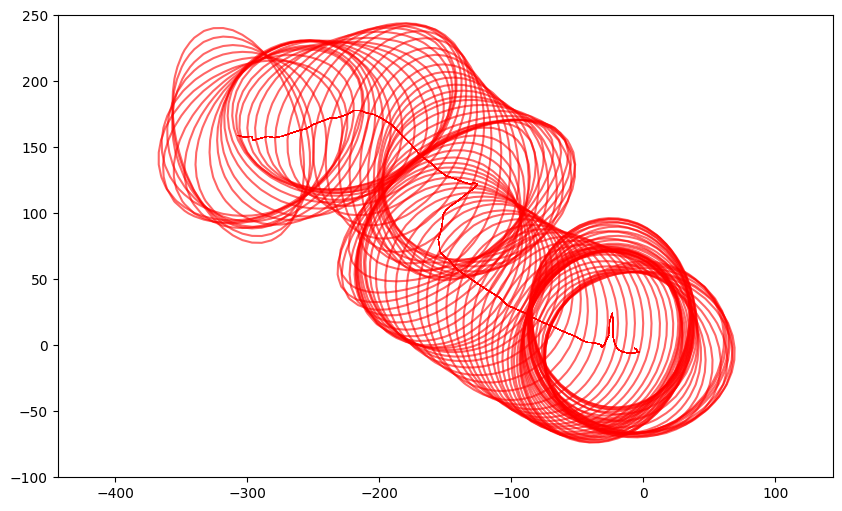

In [12]:
X, Y = x_ssh, y_ssh
fig, ax = plt.subplots(figsize=(10,6))
for t_idx in range(len(df_res)):
        
    data = df_res.iloc[t_idx]
        
    # Drifter Data
    plt.plot(df_res.sxc/1e3, df_res.syc/1e3, color='r', lw=.5, alpha=.5)
    dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
    rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
    plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2],
                colors='r', zorder=3, linewidths=1.5, alpha=.6)
    # plt.plot([], [], color='r', lw=1.5) 
    # plt.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r',
    #             s=25, zorder=5, label='Drifter Eddy Center')
plt.axis('equal'); plt.xlim(-400, 100); plt.ylim(-100, 250)


In [13]:
df_res['Data'] = 'Satellite'
df_res['Method'] = 'ESPRA'
df_res


,xc,yc,w,Q,Rc,psi0,A,r2_1,Time,Rc_opt,...,syc,sq11,sq12,sq22,sRc,sA,sw,spsi0,Data,Method
0,-5802.908374,-1563.771988,-0.000037,"[[1.0301643105849614, -0.08332720822216222], [...",86754.804799,65105.330085,-0.000009,0.992436,2023-10-19 00:00:00,85133.003389,...,-2108.042418,0.972914,-0.103055,1.041144,84608.244124,-0.000009,-0.000036,63619.485166,Satellite,ESPRA
1,-4981.140748,-26.429374,-0.000036,"[[0.9631693575540718, -0.10730452108581083], [...",82205.548129,61630.950345,-0.000009,0.989580,2023-10-19 23:56:15,84540.761002,...,-2721.266111,0.947328,-0.107706,1.072288,84434.258220,-0.000009,-0.000036,63597.153340,Satellite,ESPRA
2,-8885.799690,-4721.730306,-0.000037,"[[0.9255072352056705, -0.1185051228863016], [-...",88187.416957,66000.999166,-0.000008,0.990015,2023-10-21 00:00:00,84151.977809,...,-3128.339941,0.921162,-0.099094,1.103794,84218.946334,-0.000009,-0.000036,63588.640537,Satellite,ESPRA
3,-4142.215128,-4567.341615,-0.000038,"[[0.870303241417468, -0.12170574479314025], [-...",83651.074577,63270.612324,-0.000009,0.993006,2023-10-22 00:00:00,83910.483422,...,-4053.698867,0.899001,-0.076631,1.131550,84101.280795,-0.000009,-0.000037,63674.344288,Satellite,ESPRA
4,-1078.521019,-4746.479963,-0.000038,"[[0.8168376219820783, -0.06486040912522494], [...",82340.649335,62005.887579,-0.000009,0.992719,2023-10-22 23:56:15,83359.116296,...,-5278.160402,0.864076,-0.039283,1.175821,83688.353476,-0.000009,-0.000037,63692.856086,Satellite,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,-297737.567092,156754.359903,-0.000020,"[[0.8470330042814647, 0.00846037253683076], [0...",66220.813174,23846.353941,-0.000005,0.933604,2024-01-31 00:00:00,77891.901512,...,158109.922928,0.951670,-0.101967,1.235045,78992.514045,-0.000004,-0.000019,27527.842593,Satellite,ESPRA
105,-298005.530824,156269.898688,-0.000021,"[[0.8973369092907337, 0.2778837355453176], [0....",62172.960041,22114.972084,-0.000006,0.913641,2024-02-01 00:00:00,84215.079393,...,157995.891402,1.219022,0.051441,1.070873,81368.936855,-0.000004,-0.000019,27409.305715,Satellite,ESPRA
106,-300565.349212,165500.883450,-0.000022,"[[1.3276634948890262, 0.4330534110361884], [0....",67153.854306,25429.803854,-0.000006,0.947802,2024-02-02 00:00:00,88016.943005,...,157985.201138,1.566723,0.167942,0.934028,84635.971373,-0.000004,-0.000019,27611.138104,Satellite,ESPRA
107,-308726.488912,154030.512188,-0.000024,"[[2.4882099130928554, 0.389587848686837], [0.3...",106418.988841,30799.876268,-0.000003,0.941040,2024-02-02 23:56:15,90271.145376,...,158292.110118,1.725037,0.282861,0.819334,86909.155981,-0.000004,-0.000018,27454.212599,Satellite,ESPRA


In [14]:
df_res.to_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_satellite_ESPRA.pkl")
